In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import netCDF4 as nc
import dataset

import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
def make_clean_data(in_vars, start_year, end_year):
    if start_year < 2010 or end_year > 2020:
        print("year must be greater than 2010 and less than 2020")
        return
    
    out_data = np.load('download/cerra/si10-' + str(start_year) + '.npy')
    out_date = np.load('download/cerra/datetime_' + str(start_year) + '.npy')
    in_data = None
    for in_var in in_vars:   
        in_path = 'download/era5/'+in_var+'-2010_2020.nc'
        tmp_data = nc.Dataset(in_path)
        tmp_data = np.expand_dims(tmp_data[in_var][:], axis=3)
        if in_data is None:
            in_data = tmp_data
        else:
            in_data = np.concatenate((in_data, tmp_data), axis=3)
    return in_data[:out_data.shape[0]], out_data

In [46]:
in_data, out_data = make_clean_data(['u10', 'v10'], 2010, 2011)
u10 = in_data[:,:,:,0]
v10 = in_data[:,:,:,1]
in_data = np.sqrt(np.square(u10) + np.square(v10))
data = dataset.DownscalingDataset(in_data, out_data, low_var_name='u10*v10', high_var_name='si10')
data.get_var_name()

Low res variable name:  u10*v10
High res variable name:  si10


In [47]:
train_loader = DataLoader(data, batch_size=64, shuffle=True)
test_loader = DataLoader(data, batch_size=64, shuffle=True)

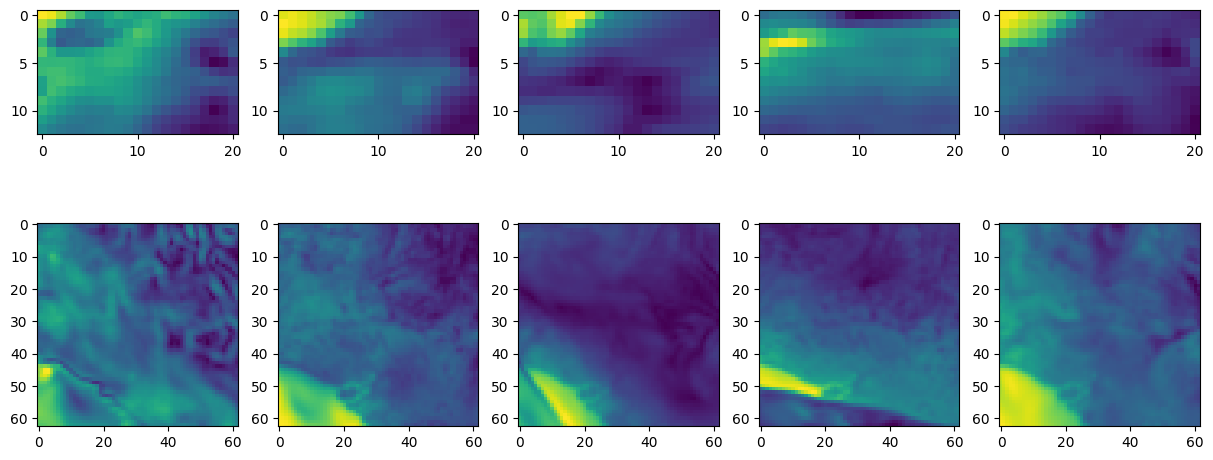

In [48]:
batch = next(iter(train_loader))
x = batch['low_res'][:5]
y = batch['high_res'][:5]

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axs[0, i].imshow(x[i].squeeze().numpy())
for i in range(5):
    axs[1, i].imshow(y[i].squeeze())

In [34]:
batch = next(iter(train_loader))
x = batch['low_res'][:5]
y = batch['high_res'][:5]
print(x.size())
input_dim = x[0].size()[0]*x[0].size()[1]
print(input_dim)

torch.Size([5, 13, 21])
273


In [48]:
n_latent = 64

class VAE(nn.Module):
    def __init__(self, in_size, out_size, n_latent):
        super().__init__()
        self.in_size = in_size
        self.n_latent = n_latent
        self.encoder = nn.Sequential(
            nn.Linear(in_size, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, self.n_latent * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.n_latent, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, out_size),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = x.to(torch.float32)
        mu_logvar = self.encoder(x.view(-1, self.in_size)).view(-1, 2, self.n_latent)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        eps = torch.randn(mu.shape).to(device)
        z = mu + (logvar.exp() ** 0.5) * eps
        return mu, logvar, z, self.decoder(z)

In [49]:
def train(model, optimizer):
    model.train()
    loss_mean = 0
    for batch in train_loader:
        x = batch["low_res"].to(device).view(-1, model.in_size)

        # ELBO = E_p(eps)[log p(x | z=g(eps, x))] - KL(q(z | x) || p(z))
        optimizer.zero_grad()
        mu, logvar, z, x_hat = model(x)
        loss = F.l1_loss(x_hat, x, reduce=False).sum(axis=1).mean()
        loss += 0.5 * (mu ** 2 + logvar.exp() - logvar - 1).sum(axis=1).mean()
        loss.backward()            
        optimizer.step()
        loss_mean += loss
    return loss_mean/len(train_loader)
                
def test(model, epoch):
    model.eval()
    
    # Evaluate test loss
    test_loss = 0
    
    for batch in test_loader:
        x = batch["low_res"].to(device).view(-1, model.in_size)
        x = x.to(torch.float32)
        mu, logvar, z, x_hat = model(x)
        loss = F.l1_loss(x_hat, x, reduce=False).sum()
        loss += 0.5 * (mu ** 2 + logvar.exp() - logvar - 1).sum()
        test_loss += loss 
        
    test_loss /= len(test_loader.dataset)
    print(f"epoch={epoch} test loss={test_loss:.4f}")
    
    # Show reconstructions
    batch = next(iter(test_loader))
    x = batch["low_res"][:5].to(device)

    fig, axs = plt.subplots(2, 5, figsize=(10, 4))

    for i in range(5):
        axs[0, i].imshow(x[i].squeeze().cpu().numpy())
        
    _, _, _, x_hat = model(x)
    
    for i in range(5):
        axs[1, i].imshow(x_hat[i].view(13, 21).detach().cpu().numpy())
        
    plt.show()

In [50]:
# Training
model = VAE(in_size=input_dim, out_size=input_dim, n_latent=32).to(device)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in range(100):
    loss = train(model, optimizer)
    print("loss = ", loss)
    
test(model, epoch+1)

loss =  tensor(832.0245, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(804.0004, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(805.5441, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(804.5824, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(805.1454, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(805.0171, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(804.5030, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(805.2367, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(805.0552, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(804.7185, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(805.3512, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
loss =  tensor(804.9328, device='cuda:0', d

KeyboardInterrupt: 